<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:01:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


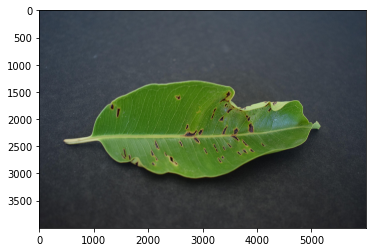

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

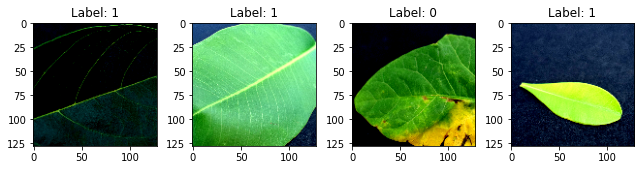

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:01:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:01:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2526260421461388 samples/sec                   batch loss = 0.720233142375946 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2657305948578066 samples/sec                   batch loss = 0.6895965933799744 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.273959307027302 samples/sec                   batch loss = 0.7702915668487549 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2632654339728113 samples/sec                   batch loss = 0.5909113883972168 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2695026219806287 samples/sec                   batch loss = 0.5042638182640076 | accuracy = 0.67


Epoch[1] Batch[30] Speed: 1.263206462666883 samples/sec                   batch loss = 0.6385877132415771 | accuracy = 0.6833333333333333


Epoch[1] Batch[35] Speed: 1.2685275833337113 samples/sec                   batch loss = 0.5859283208847046 | accuracy = 0.6785714285714286


Epoch[1] Batch[40] Speed: 1.262343448704687 samples/sec                   batch loss = 1.0614396333694458 | accuracy = 0.675


Epoch[1] Batch[45] Speed: 1.2703577566696143 samples/sec                   batch loss = 0.31384897232055664 | accuracy = 0.6888888888888889


Epoch[1] Batch[50] Speed: 1.2680288372513462 samples/sec                   batch loss = 0.5736459493637085 | accuracy = 0.675


Epoch[1] Batch[55] Speed: 1.2597804809901145 samples/sec                   batch loss = 1.3520135879516602 | accuracy = 0.6681818181818182


Epoch[1] Batch[60] Speed: 1.2679607958250414 samples/sec                   batch loss = 0.9563450813293457 | accuracy = 0.6666666666666666


Epoch[1] Batch[65] Speed: 1.2674323339076505 samples/sec                   batch loss = 0.5239489078521729 | accuracy = 0.6730769230769231


Epoch[1] Batch[70] Speed: 1.269202886243832 samples/sec                   batch loss = 0.5265560150146484 | accuracy = 0.6642857142857143


Epoch[1] Batch[75] Speed: 1.2641277092367387 samples/sec                   batch loss = 0.86383056640625 | accuracy = 0.6666666666666666


Epoch[1] Batch[80] Speed: 1.262179343467552 samples/sec                   batch loss = 0.49704283475875854 | accuracy = 0.66875


Epoch[1] Batch[85] Speed: 1.2645702020384364 samples/sec                   batch loss = 1.2299836874008179 | accuracy = 0.6617647058823529


Epoch[1] Batch[90] Speed: 1.2640594191444108 samples/sec                   batch loss = 0.7664554119110107 | accuracy = 0.6611111111111111


Epoch[1] Batch[95] Speed: 1.2680509762476107 samples/sec                   batch loss = 0.39576447010040283 | accuracy = 0.6631578947368421


Epoch[1] Batch[100] Speed: 1.2594418260522813 samples/sec                   batch loss = 0.6012277603149414 | accuracy = 0.6675


Epoch[1] Batch[105] Speed: 1.2619266213069922 samples/sec                   batch loss = 0.5905815362930298 | accuracy = 0.669047619047619


Epoch[1] Batch[110] Speed: 1.2608769433916605 samples/sec                   batch loss = 0.650903046131134 | accuracy = 0.675


Epoch[1] Batch[115] Speed: 1.273784721233635 samples/sec                   batch loss = 0.8695220947265625 | accuracy = 0.6717391304347826


Epoch[1] Batch[120] Speed: 1.266027832784756 samples/sec                   batch loss = 0.8569976687431335 | accuracy = 0.6645833333333333


Epoch[1] Batch[125] Speed: 1.2640019926026285 samples/sec                   batch loss = 0.47447094321250916 | accuracy = 0.67


Epoch[1] Batch[130] Speed: 1.2587033938939154 samples/sec                   batch loss = 0.5452655553817749 | accuracy = 0.6711538461538461


Epoch[1] Batch[135] Speed: 1.2737244736435733 samples/sec                   batch loss = 0.26185277104377747 | accuracy = 0.6759259259259259


Epoch[1] Batch[140] Speed: 1.2717099013662463 samples/sec                   batch loss = 0.3631287217140198 | accuracy = 0.6803571428571429


Epoch[1] Batch[145] Speed: 1.2698011538337821 samples/sec                   batch loss = 0.7043790221214294 | accuracy = 0.6844827586206896


Epoch[1] Batch[150] Speed: 1.2654602219765303 samples/sec                   batch loss = 0.390824556350708 | accuracy = 0.6883333333333334


Epoch[1] Batch[155] Speed: 1.274471830638191 samples/sec                   batch loss = 1.0115739107131958 | accuracy = 0.6887096774193548


Epoch[1] Batch[160] Speed: 1.2787298748595584 samples/sec                   batch loss = 0.21826857328414917 | accuracy = 0.6921875


Epoch[1] Batch[165] Speed: 1.2723633156070335 samples/sec                   batch loss = 0.3352169394493103 | accuracy = 0.696969696969697


Epoch[1] Batch[170] Speed: 1.2749431043921555 samples/sec                   batch loss = 1.2771122455596924 | accuracy = 0.6941176470588235


Epoch[1] Batch[175] Speed: 1.2702671516793174 samples/sec                   batch loss = 0.6652783155441284 | accuracy = 0.6957142857142857


Epoch[1] Batch[180] Speed: 1.2707104889638885 samples/sec                   batch loss = 1.2337770462036133 | accuracy = 0.6902777777777778


Epoch[1] Batch[185] Speed: 1.2774921302792195 samples/sec                   batch loss = 0.2728661894798279 | accuracy = 0.6851351351351351


Epoch[1] Batch[190] Speed: 1.2713145140995732 samples/sec                   batch loss = 0.8145204186439514 | accuracy = 0.6815789473684211


Epoch[1] Batch[195] Speed: 1.2715633008985412 samples/sec                   batch loss = 0.8969599604606628 | accuracy = 0.6782051282051282


Epoch[1] Batch[200] Speed: 1.2733493841446097 samples/sec                   batch loss = 0.20227153599262238 | accuracy = 0.67875


Epoch[1] Batch[205] Speed: 1.2742481315078231 samples/sec                   batch loss = 1.1664382219314575 | accuracy = 0.6792682926829269


Epoch[1] Batch[210] Speed: 1.276225906953474 samples/sec                   batch loss = 0.3970339894294739 | accuracy = 0.6773809523809524


Epoch[1] Batch[215] Speed: 1.2695533442390776 samples/sec                   batch loss = 0.36598095297813416 | accuracy = 0.6790697674418604


Epoch[1] Batch[220] Speed: 1.2641660006339963 samples/sec                   batch loss = 0.39087167382240295 | accuracy = 0.678409090909091


Epoch[1] Batch[225] Speed: 1.271467127764924 samples/sec                   batch loss = 0.4362611770629883 | accuracy = 0.6833333333333333


Epoch[1] Batch[230] Speed: 1.2703847867758107 samples/sec                   batch loss = 1.040494441986084 | accuracy = 0.6826086956521739


Epoch[1] Batch[235] Speed: 1.2747044216030023 samples/sec                   batch loss = 1.2740107774734497 | accuracy = 0.6819148936170213


Epoch[1] Batch[240] Speed: 1.2681705977030209 samples/sec                   batch loss = 0.6910459399223328 | accuracy = 0.68125


Epoch[1] Batch[245] Speed: 1.2617362446423714 samples/sec                   batch loss = 0.651494026184082 | accuracy = 0.6816326530612244


Epoch[1] Batch[250] Speed: 1.2616278903630376 samples/sec                   batch loss = 0.6879084706306458 | accuracy = 0.682


Epoch[1] Batch[255] Speed: 1.266569561985616 samples/sec                   batch loss = 0.5058794617652893 | accuracy = 0.6813725490196079


Epoch[1] Batch[260] Speed: 1.268483560545248 samples/sec                   batch loss = 0.5873674750328064 | accuracy = 0.6798076923076923


Epoch[1] Batch[265] Speed: 1.2686142951035462 samples/sec                   batch loss = 0.3055576682090759 | accuracy = 0.6792452830188679


Epoch[1] Batch[270] Speed: 1.2637330239611302 samples/sec                   batch loss = 0.5618242025375366 | accuracy = 0.6787037037037037


Epoch[1] Batch[275] Speed: 1.2665601915223923 samples/sec                   batch loss = 0.5559688210487366 | accuracy = 0.6763636363636364


Epoch[1] Batch[280] Speed: 1.2663541719896207 samples/sec                   batch loss = 0.40264129638671875 | accuracy = 0.6776785714285715


Epoch[1] Batch[285] Speed: 1.2680656401642318 samples/sec                   batch loss = 0.5474242568016052 | accuracy = 0.6798245614035088


Epoch[1] Batch[290] Speed: 1.259463288022416 samples/sec                   batch loss = 0.6782776117324829 | accuracy = 0.6793103448275862


Epoch[1] Batch[295] Speed: 1.2609618541590162 samples/sec                   batch loss = 0.46728840470314026 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.2743797666616914 samples/sec                   batch loss = 0.47082191705703735 | accuracy = 0.68


Epoch[1] Batch[305] Speed: 1.2719871949226098 samples/sec                   batch loss = 0.9354585409164429 | accuracy = 0.6778688524590164


Epoch[1] Batch[310] Speed: 1.2715174289319429 samples/sec                   batch loss = 0.6796861886978149 | accuracy = 0.6782258064516129


Epoch[1] Batch[315] Speed: 1.2572985627846816 samples/sec                   batch loss = 0.4387044310569763 | accuracy = 0.680952380952381


Epoch[1] Batch[320] Speed: 1.2715255237443743 samples/sec                   batch loss = 0.4399580657482147 | accuracy = 0.67890625


Epoch[1] Batch[325] Speed: 1.2584997334058254 samples/sec                   batch loss = 0.5537697672843933 | accuracy = 0.6792307692307692


Epoch[1] Batch[330] Speed: 1.2681004323821379 samples/sec                   batch loss = 0.6358370184898376 | accuracy = 0.678030303030303


Epoch[1] Batch[335] Speed: 1.2658613356057227 samples/sec                   batch loss = 0.6509559154510498 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2623259725059206 samples/sec                   batch loss = 0.2393789142370224 | accuracy = 0.6757352941176471


Epoch[1] Batch[345] Speed: 1.2706685279975183 samples/sec                   batch loss = 0.7743829488754272 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.267931281533499 samples/sec                   batch loss = 0.46102574467658997 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2806704681970802 samples/sec                   batch loss = 0.21276208758354187 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2654558312799578 samples/sec                   batch loss = 0.842849850654602 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.26448518584648 samples/sec                   batch loss = 0.8554681539535522 | accuracy = 0.6698630136986301


Epoch[1] Batch[370] Speed: 1.270225700839162 samples/sec                   batch loss = 0.2916960120201111 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.2705062921701258 samples/sec                   batch loss = 0.7314736843109131 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.2719629895908413 samples/sec                   batch loss = 0.17048677802085876 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.26583573923531 samples/sec                   batch loss = 0.5081691145896912 | accuracy = 0.6714285714285714


Epoch[1] Batch[390] Speed: 1.262486220776552 samples/sec                   batch loss = 0.9045565724372864 | accuracy = 0.6685897435897435


Epoch[1] Batch[395] Speed: 1.2712286850116665 samples/sec                   batch loss = 0.22076380252838135 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.2731181568503567 samples/sec                   batch loss = 1.2414542436599731 | accuracy = 0.67


Epoch[1] Batch[405] Speed: 1.2711320809468187 samples/sec                   batch loss = 0.5196471214294434 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2667700083584452 samples/sec                   batch loss = 0.3693959712982178 | accuracy = 0.6719512195121952


Epoch[1] Batch[415] Speed: 1.2696643133113095 samples/sec                   batch loss = 0.4837786853313446 | accuracy = 0.6716867469879518


Epoch[1] Batch[420] Speed: 1.2731818253566412 samples/sec                   batch loss = 0.4234657287597656 | accuracy = 0.6726190476190477


Epoch[1] Batch[425] Speed: 1.2704636712421298 samples/sec                   batch loss = 0.656069278717041 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.2709980346261256 samples/sec                   batch loss = 0.5487743020057678 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.2653050388915839 samples/sec                   batch loss = 0.35916751623153687 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.2726101963308003 samples/sec                   batch loss = 0.5533126592636108 | accuracy = 0.6755681818181818


Epoch[1] Batch[445] Speed: 1.2736216887458067 samples/sec                   batch loss = 0.37917858362197876 | accuracy = 0.6780898876404494


Epoch[1] Batch[450] Speed: 1.2753258226627429 samples/sec                   batch loss = 0.256580650806427 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.269052447491617 samples/sec                   batch loss = 0.18287023901939392 | accuracy = 0.682967032967033


Epoch[1] Batch[460] Speed: 1.2728442327136253 samples/sec                   batch loss = 1.2944386005401611 | accuracy = 0.6815217391304348


Epoch[1] Batch[465] Speed: 1.2730893680232631 samples/sec                   batch loss = 0.4625254273414612 | accuracy = 0.6811827956989247


Epoch[1] Batch[470] Speed: 1.2694674646116948 samples/sec                   batch loss = 1.436953067779541 | accuracy = 0.6813829787234043


Epoch[1] Batch[475] Speed: 1.272972873515077 samples/sec                   batch loss = 0.4398168921470642 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.2618782150139989 samples/sec                   batch loss = 0.5200759172439575 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.266490204284497 samples/sec                   batch loss = 0.7200528383255005 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2692812398835003 samples/sec                   batch loss = 0.3909918963909149 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2727093423264133 samples/sec                   batch loss = 0.6660645604133606 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.2665602871386636 samples/sec                   batch loss = 0.7406985759735107 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.2623599755552108 samples/sec                   batch loss = 0.440995991230011 | accuracy = 0.6831683168316832


Epoch[1] Batch[510] Speed: 1.2718439050601253 samples/sec                   batch loss = 1.4326108694076538 | accuracy = 0.6833333333333333


Epoch[1] Batch[515] Speed: 1.2701652124722758 samples/sec                   batch loss = 0.43185001611709595 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.2756138123391485 samples/sec                   batch loss = 0.9277501702308655 | accuracy = 0.6826923076923077


Epoch[1] Batch[525] Speed: 1.2688929272968579 samples/sec                   batch loss = 0.4224511384963989 | accuracy = 0.6842857142857143


Epoch[1] Batch[530] Speed: 1.264231825347307 samples/sec                   batch loss = 0.751675546169281 | accuracy = 0.685377358490566


Epoch[1] Batch[535] Speed: 1.2682126814495158 samples/sec                   batch loss = 0.339175283908844 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.2730265781187176 samples/sec                   batch loss = 0.7383019924163818 | accuracy = 0.687962962962963


Epoch[1] Batch[545] Speed: 1.2654381733514084 samples/sec                   batch loss = 0.5845564007759094 | accuracy = 0.6876146788990826


Epoch[1] Batch[550] Speed: 1.2653261285765065 samples/sec                   batch loss = 0.7235557436943054 | accuracy = 0.6877272727272727


Epoch[1] Batch[555] Speed: 1.266214633032297 samples/sec                   batch loss = 0.28798794746398926 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.271630380152483 samples/sec                   batch loss = 0.23530268669128418 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2768386864431418 samples/sec                   batch loss = 0.4108145236968994 | accuracy = 0.6876106194690266


Epoch[1] Batch[570] Speed: 1.272667152706941 samples/sec                   batch loss = 0.8882678151130676 | accuracy = 0.6881578947368421


Epoch[1] Batch[575] Speed: 1.272458176733572 samples/sec                   batch loss = 0.3330087661743164 | accuracy = 0.69


Epoch[1] Batch[580] Speed: 1.2708169436643808 samples/sec                   batch loss = 0.675747275352478 | accuracy = 0.6905172413793104


Epoch[1] Batch[585] Speed: 1.2721671726101695 samples/sec                   batch loss = 1.569434404373169 | accuracy = 0.6901709401709402


Epoch[1] Batch[590] Speed: 1.2723463328086624 samples/sec                   batch loss = 0.5056713819503784 | accuracy = 0.6902542372881356


Epoch[1] Batch[595] Speed: 1.2697117813311558 samples/sec                   batch loss = 0.33254674077033997 | accuracy = 0.6903361344537815


Epoch[1] Batch[600] Speed: 1.2690288336703348 samples/sec                   batch loss = 0.4333210289478302 | accuracy = 0.6916666666666667


Epoch[1] Batch[605] Speed: 1.2738372370243691 samples/sec                   batch loss = 0.8878895044326782 | accuracy = 0.6929752066115702


Epoch[1] Batch[610] Speed: 1.2767406449340715 samples/sec                   batch loss = 0.3816455006599426 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.273639769176356 samples/sec                   batch loss = 0.73009192943573 | accuracy = 0.6922764227642276


Epoch[1] Batch[620] Speed: 1.2683166086329392 samples/sec                   batch loss = 0.27327826619148254 | accuracy = 0.6923387096774194


Epoch[1] Batch[625] Speed: 1.2699943567467156 samples/sec                   batch loss = 0.9371827244758606 | accuracy = 0.692


Epoch[1] Batch[630] Speed: 1.2768925233680424 samples/sec                   batch loss = 0.2984953224658966 | accuracy = 0.6932539682539682


Epoch[1] Batch[635] Speed: 1.2699698426732229 samples/sec                   batch loss = 0.5810235738754272 | accuracy = 0.6940944881889763


Epoch[1] Batch[640] Speed: 1.2756695829449802 samples/sec                   batch loss = 0.7950150966644287 | accuracy = 0.692578125


Epoch[1] Batch[645] Speed: 1.2634192608523922 samples/sec                   batch loss = 0.8567489385604858 | accuracy = 0.6937984496124031


Epoch[1] Batch[650] Speed: 1.2730509205465437 samples/sec                   batch loss = 0.7594871520996094 | accuracy = 0.6938461538461539


Epoch[1] Batch[655] Speed: 1.2770858489489583 samples/sec                   batch loss = 0.4842534065246582 | accuracy = 0.6935114503816794


Epoch[1] Batch[660] Speed: 1.2663183285688817 samples/sec                   batch loss = 1.2385196685791016 | accuracy = 0.6935606060606061


Epoch[1] Batch[665] Speed: 1.2671933919778182 samples/sec                   batch loss = 0.2781502604484558 | accuracy = 0.693609022556391


Epoch[1] Batch[670] Speed: 1.2659061317448983 samples/sec                   batch loss = 0.24548448622226715 | accuracy = 0.6936567164179105


Epoch[1] Batch[675] Speed: 1.2706309002217309 samples/sec                   batch loss = 0.7049151062965393 | accuracy = 0.6944444444444444


Epoch[1] Batch[680] Speed: 1.2710779582676317 samples/sec                   batch loss = 0.2531787157058716 | accuracy = 0.6933823529411764


Epoch[1] Batch[685] Speed: 1.2752760921610562 samples/sec                   batch loss = 0.5412971377372742 | accuracy = 0.6941605839416058


Epoch[1] Batch[690] Speed: 1.2719241279771034 samples/sec                   batch loss = 0.8484266996383667 | accuracy = 0.6934782608695652


Epoch[1] Batch[695] Speed: 1.263825745705594 samples/sec                   batch loss = 0.22268277406692505 | accuracy = 0.6953237410071943


Epoch[1] Batch[700] Speed: 1.2695808204881085 samples/sec                   batch loss = 0.30620455741882324 | accuracy = 0.6964285714285714


Epoch[1] Batch[705] Speed: 1.2654506770228584 samples/sec                   batch loss = 0.4452802240848541 | accuracy = 0.6960992907801419


Epoch[1] Batch[710] Speed: 1.272231807251135 samples/sec                   batch loss = 0.4020605981349945 | accuracy = 0.696830985915493


Epoch[1] Batch[715] Speed: 1.2661550993991029 samples/sec                   batch loss = 0.28880396485328674 | accuracy = 0.6965034965034965


Epoch[1] Batch[720] Speed: 1.271580551927219 samples/sec                   batch loss = 0.29437491297721863 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.27262718617385 samples/sec                   batch loss = 0.5248210430145264 | accuracy = 0.6962068965517242


Epoch[1] Batch[730] Speed: 1.2693393392075618 samples/sec                   batch loss = 0.3167792558670044 | accuracy = 0.6965753424657535


Epoch[1] Batch[735] Speed: 1.2694336538970816 samples/sec                   batch loss = 0.5998159050941467 | accuracy = 0.6969387755102041


Epoch[1] Batch[740] Speed: 1.2628529405344455 samples/sec                   batch loss = 0.22247891128063202 | accuracy = 0.6983108108108108


Epoch[1] Batch[745] Speed: 1.2671379772155256 samples/sec                   batch loss = 0.9465224146842957 | accuracy = 0.696979865771812


Epoch[1] Batch[750] Speed: 1.2729034312943721 samples/sec                   batch loss = 0.4124484658241272 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2729212981793978 samples/sec                   batch loss = 0.4393336772918701 | accuracy = 0.6960264900662252


Epoch[1] Batch[760] Speed: 1.2685576049831888 samples/sec                   batch loss = 0.41227972507476807 | accuracy = 0.6960526315789474


Epoch[1] Batch[765] Speed: 1.2666954073539416 samples/sec                   batch loss = 1.220674991607666 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.2693688230476339 samples/sec                   batch loss = 0.20953114330768585 | accuracy = 0.6983766233766234


Epoch[1] Batch[775] Speed: 1.2763080429497955 samples/sec                   batch loss = 0.7996196746826172 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.279847283847661 samples/sec                   batch loss = 0.3542446494102478 | accuracy = 0.698076923076923


Epoch[1] Batch[785] Speed: 1.272709825061357 samples/sec                   batch loss = 0.274677038192749 | accuracy = 0.6987261146496815


[Epoch 1] training: accuracy=0.699238578680203
[Epoch 1] time cost: 648.6277313232422
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2646958410609046 samples/sec                   batch loss = 0.42823025584220886 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2707666016508923 samples/sec                   batch loss = 0.2655213475227356 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2750985287268544 samples/sec                   batch loss = 0.3992367684841156 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.266211479424951 samples/sec                   batch loss = 0.4548063278198242 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2678349863390403 samples/sec                   batch loss = 0.7256085276603699 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.267162764912498 samples/sec                   batch loss = 0.08745263516902924 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2708006759236403 samples/sec                   batch loss = 0.5638684630393982 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2728389215277633 samples/sec                   batch loss = 0.45331981778144836 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2744211018385854 samples/sec                   batch loss = 0.29683929681777954 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2688084803746738 samples/sec                   batch loss = 0.9181853532791138 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2742569385993334 samples/sec                   batch loss = 0.6655502319335938 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2722404900167148 samples/sec                   batch loss = 0.5175665020942688 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2742323564724125 samples/sec                   batch loss = 0.411927193403244 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.267039984388202 samples/sec                   batch loss = 0.5851882100105286 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2726625187773524 samples/sec                   batch loss = 0.44698768854141235 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2725074946669828 samples/sec                   batch loss = 0.403766006231308 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2696619111779361 samples/sec                   batch loss = 0.7120969891548157 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.2752937348970816 samples/sec                   batch loss = 0.3577616512775421 | accuracy = 0.7666666666666667


Epoch[2] Batch[95] Speed: 1.2690554232794127 samples/sec                   batch loss = 0.8487703800201416 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.272166111499219 samples/sec                   batch loss = 0.9791610836982727 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2711831261307016 samples/sec                   batch loss = 0.9264572262763977 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.270628301966529 samples/sec                   batch loss = 0.5750046968460083 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2724428320115706 samples/sec                   batch loss = 0.779399573802948 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.2623080219142337 samples/sec                   batch loss = 0.5955537557601929 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.269166305320399 samples/sec                   batch loss = 0.5429754257202148 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2703775722221213 samples/sec                   batch loss = 0.6714354753494263 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2769881582699008 samples/sec                   batch loss = 0.24795198440551758 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.2697947147490618 samples/sec                   batch loss = 0.8868705034255981 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.26440170573334 samples/sec                   batch loss = 0.9628993272781372 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.2705448747536965 samples/sec                   batch loss = 0.3547922372817993 | accuracy = 0.7433333333333333


Epoch[2] Batch[155] Speed: 1.2682991584141725 samples/sec                   batch loss = 0.4560263156890869 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2701724246141515 samples/sec                   batch loss = 0.6555238366127014 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.262754088637768 samples/sec                   batch loss = 0.7873448729515076 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2660882143548724 samples/sec                   batch loss = 0.21504758298397064 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2734325034812677 samples/sec                   batch loss = 0.23845668137073517 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2750363156857163 samples/sec                   batch loss = 0.47677260637283325 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.2716248863268242 samples/sec                   batch loss = 0.34170669317245483 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.2689995575917714 samples/sec                   batch loss = 0.24673186242580414 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2720738016221254 samples/sec                   batch loss = 0.12332822382450104 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2689984057736756 samples/sec                   batch loss = 0.28323787450790405 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.2775311383259738 samples/sec                   batch loss = 0.41538506746292114 | accuracy = 0.7560975609756098


Epoch[2] Batch[210] Speed: 1.2731632748461326 samples/sec                   batch loss = 0.4532264173030853 | accuracy = 0.7583333333333333


Epoch[2] Batch[215] Speed: 1.2742734885182048 samples/sec                   batch loss = 0.15665417909622192 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.2704978254827821 samples/sec                   batch loss = 0.48856422305107117 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2711947804173211 samples/sec                   batch loss = 0.37432947754859924 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.271044158007157 samples/sec                   batch loss = 0.5471336245536804 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.2686784732830432 samples/sec                   batch loss = 0.2816866934299469 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2645943174564984 samples/sec                   batch loss = 0.07439137995243073 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2724577906982917 samples/sec                   batch loss = 0.5688979029655457 | accuracy = 0.753061224489796


Epoch[2] Batch[250] Speed: 1.271571589043843 samples/sec                   batch loss = 0.43751487135887146 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.2724749694949726 samples/sec                   batch loss = 0.9002038240432739 | accuracy = 0.7568627450980392


Epoch[2] Batch[260] Speed: 1.2697394566323752 samples/sec                   batch loss = 0.36086171865463257 | accuracy = 0.7576923076923077


Epoch[2] Batch[265] Speed: 1.2701703090440457 samples/sec                   batch loss = 0.24807637929916382 | accuracy = 0.7594339622641509


Epoch[2] Batch[270] Speed: 1.274573590843974 samples/sec                   batch loss = 0.3298678696155548 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.278532153941916 samples/sec                   batch loss = 0.30457445979118347 | accuracy = 0.7572727272727273


Epoch[2] Batch[280] Speed: 1.2716671032589186 samples/sec                   batch loss = 0.3306939899921417 | accuracy = 0.75625


Epoch[2] Batch[285] Speed: 1.2674248656083853 samples/sec                   batch loss = 0.3213748037815094 | accuracy = 0.7578947368421053


Epoch[2] Batch[290] Speed: 1.2667333762543818 samples/sec                   batch loss = 0.3904162645339966 | accuracy = 0.7594827586206897


Epoch[2] Batch[295] Speed: 1.2661158274666395 samples/sec                   batch loss = 0.6049835681915283 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2705376583816086 samples/sec                   batch loss = 0.4676159918308258 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2666487383730964 samples/sec                   batch loss = 0.35354161262512207 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.2540743436675592 samples/sec                   batch loss = 1.0239185094833374 | accuracy = 0.757258064516129


Epoch[2] Batch[315] Speed: 1.2699354284336222 samples/sec                   batch loss = 0.8457211256027222 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2617857788036857 samples/sec                   batch loss = 0.17096351087093353 | accuracy = 0.759375


Epoch[2] Batch[325] Speed: 1.2637231242912974 samples/sec                   batch loss = 0.39144498109817505 | accuracy = 0.7592307692307693


Epoch[2] Batch[330] Speed: 1.2741960656959348 samples/sec                   batch loss = 0.631854236125946 | accuracy = 0.7575757575757576


Epoch[2] Batch[335] Speed: 1.267071275372347 samples/sec                   batch loss = 0.6406140327453613 | accuracy = 0.7567164179104477


Epoch[2] Batch[340] Speed: 1.2686486377760997 samples/sec                   batch loss = 0.4742037355899811 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2681859354192735 samples/sec                   batch loss = 0.7898315787315369 | accuracy = 0.758695652173913


Epoch[2] Batch[350] Speed: 1.2701681934809874 samples/sec                   batch loss = 0.12199269980192184 | accuracy = 0.7607142857142857


Epoch[2] Batch[355] Speed: 1.2628348798978726 samples/sec                   batch loss = 0.21722370386123657 | accuracy = 0.7619718309859155


Epoch[2] Batch[360] Speed: 1.267063045789424 samples/sec                   batch loss = 0.36900877952575684 | accuracy = 0.7631944444444444


Epoch[2] Batch[365] Speed: 1.2710158480612808 samples/sec                   batch loss = 0.8903064131736755 | accuracy = 0.7623287671232877


Epoch[2] Batch[370] Speed: 1.273739752589279 samples/sec                   batch loss = 0.3233787417411804 | accuracy = 0.7628378378378379


Epoch[2] Batch[375] Speed: 1.2752606794010692 samples/sec                   batch loss = 0.09445087611675262 | accuracy = 0.7646666666666667


Epoch[2] Batch[380] Speed: 1.2666452957156276 samples/sec                   batch loss = 0.4112405478954315 | accuracy = 0.7671052631578947


Epoch[2] Batch[385] Speed: 1.2706849848352133 samples/sec                   batch loss = 0.5677890181541443 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.2737788219402066 samples/sec                   batch loss = 0.19154657423496246 | accuracy = 0.7660256410256411


Epoch[2] Batch[395] Speed: 1.2735115735715403 samples/sec                   batch loss = 0.3763141632080078 | accuracy = 0.7658227848101266


Epoch[2] Batch[400] Speed: 1.2707282943398142 samples/sec                   batch loss = 0.47001293301582336 | accuracy = 0.76375


Epoch[2] Batch[405] Speed: 1.2663038961911364 samples/sec                   batch loss = 0.08503538370132446 | accuracy = 0.7641975308641975


Epoch[2] Batch[410] Speed: 1.2697544479242768 samples/sec                   batch loss = 0.26453688740730286 | accuracy = 0.7652439024390244


Epoch[2] Batch[415] Speed: 1.2743071703825568 samples/sec                   batch loss = 0.6691734194755554 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.2676444512009637 samples/sec                   batch loss = 0.5072494149208069 | accuracy = 0.7613095238095238


Epoch[2] Batch[425] Speed: 1.2727700732571137 samples/sec                   batch loss = 0.37319713830947876 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2667381583931592 samples/sec                   batch loss = 0.848752498626709 | accuracy = 0.7616279069767442


Epoch[2] Batch[435] Speed: 1.2708438970509257 samples/sec                   batch loss = 0.41900745034217834 | accuracy = 0.7626436781609195


Epoch[2] Batch[440] Speed: 1.272379719876815 samples/sec                   batch loss = 0.8067320585250854 | accuracy = 0.7625


Epoch[2] Batch[445] Speed: 1.2657660230282404 samples/sec                   batch loss = 0.4172259569168091 | accuracy = 0.7629213483146068


Epoch[2] Batch[450] Speed: 1.2662142507760246 samples/sec                   batch loss = 0.33231574296951294 | accuracy = 0.7633333333333333


Epoch[2] Batch[455] Speed: 1.2697499312798417 samples/sec                   batch loss = 0.23385663330554962 | accuracy = 0.7648351648351648


Epoch[2] Batch[460] Speed: 1.2707488914511746 samples/sec                   batch loss = 0.49191564321517944 | accuracy = 0.7635869565217391


Epoch[2] Batch[465] Speed: 1.2723529907835416 samples/sec                   batch loss = 0.06787160784006119 | accuracy = 0.7650537634408602


Epoch[2] Batch[470] Speed: 1.2762524106764135 samples/sec                   batch loss = 0.831636369228363 | accuracy = 0.7638297872340426


Epoch[2] Batch[475] Speed: 1.2704981141179927 samples/sec                   batch loss = 0.7386584877967834 | accuracy = 0.7631578947368421


Epoch[2] Batch[480] Speed: 1.2763061010784598 samples/sec                   batch loss = 0.794880747795105 | accuracy = 0.7625


Epoch[2] Batch[485] Speed: 1.2703509271806848 samples/sec                   batch loss = 0.24034421145915985 | accuracy = 0.7623711340206185


Epoch[2] Batch[490] Speed: 1.272936074955144 samples/sec                   batch loss = 0.37010252475738525 | accuracy = 0.7637755102040816


Epoch[2] Batch[495] Speed: 1.2709423828942463 samples/sec                   batch loss = 0.385022908449173 | accuracy = 0.7651515151515151


Epoch[2] Batch[500] Speed: 1.26685274923593 samples/sec                   batch loss = 0.5599129796028137 | accuracy = 0.764


Epoch[2] Batch[505] Speed: 1.2715411354594128 samples/sec                   batch loss = 0.5547761917114258 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.2720525828544653 samples/sec                   batch loss = 0.3420030474662781 | accuracy = 0.7627450980392156


Epoch[2] Batch[515] Speed: 1.273152550578838 samples/sec                   batch loss = 0.5257627964019775 | accuracy = 0.7631067961165049


Epoch[2] Batch[520] Speed: 1.2717511599264293 samples/sec                   batch loss = 0.29084378480911255 | accuracy = 0.7639423076923076


Epoch[2] Batch[525] Speed: 1.2694955135030754 samples/sec                   batch loss = 0.7061499357223511 | accuracy = 0.7633333333333333


Epoch[2] Batch[530] Speed: 1.2731349670360408 samples/sec                   batch loss = 0.7255878448486328 | accuracy = 0.7632075471698113


Epoch[2] Batch[535] Speed: 1.2737440075508049 samples/sec                   batch loss = 0.7963801622390747 | accuracy = 0.7635514018691589


Epoch[2] Batch[540] Speed: 1.2718909576593203 samples/sec                   batch loss = 0.23065635561943054 | accuracy = 0.763425925925926


Epoch[2] Batch[545] Speed: 1.2622446765514268 samples/sec                   batch loss = 0.41768980026245117 | accuracy = 0.763302752293578


Epoch[2] Batch[550] Speed: 1.265200459710479 samples/sec                   batch loss = 0.4860771596431732 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2692523362506267 samples/sec                   batch loss = 2.0131216049194336 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.2714537340638357 samples/sec                   batch loss = 0.2904982268810272 | accuracy = 0.7638392857142857


Epoch[2] Batch[565] Speed: 1.274879937750003 samples/sec                   batch loss = 0.7900733947753906 | accuracy = 0.7632743362831859


Epoch[2] Batch[570] Speed: 1.2707997133484819 samples/sec                   batch loss = 0.35293498635292053 | accuracy = 0.7635964912280702


Epoch[2] Batch[575] Speed: 1.2735582662674914 samples/sec                   batch loss = 0.993972897529602 | accuracy = 0.7630434782608696


Epoch[2] Batch[580] Speed: 1.2692920910888625 samples/sec                   batch loss = 0.16077080368995667 | accuracy = 0.7637931034482759


Epoch[2] Batch[585] Speed: 1.2740631139518102 samples/sec                   batch loss = 0.3478793799877167 | accuracy = 0.764102564102564


Epoch[2] Batch[590] Speed: 1.2652692548356126 samples/sec                   batch loss = 0.24461732804775238 | accuracy = 0.7648305084745762


Epoch[2] Batch[595] Speed: 1.2623216985092125 samples/sec                   batch loss = 0.55399489402771 | accuracy = 0.7647058823529411


Epoch[2] Batch[600] Speed: 1.265463658195101 samples/sec                   batch loss = 0.2276943176984787 | accuracy = 0.7658333333333334


Epoch[2] Batch[605] Speed: 1.272738017417253 samples/sec                   batch loss = 0.4523134231567383 | accuracy = 0.7644628099173554


Epoch[2] Batch[610] Speed: 1.2736924664076192 samples/sec                   batch loss = 0.41167888045310974 | accuracy = 0.764344262295082


Epoch[2] Batch[615] Speed: 1.2736351281612535 samples/sec                   batch loss = 0.11574531346559525 | accuracy = 0.7638211382113821


Epoch[2] Batch[620] Speed: 1.2650548791641953 samples/sec                   batch loss = 1.188575029373169 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.272517435926686 samples/sec                   batch loss = 1.0664348602294922 | accuracy = 0.7624


Epoch[2] Batch[630] Speed: 1.2770167348920902 samples/sec                   batch loss = 0.2773320972919464 | accuracy = 0.7615079365079365


Epoch[2] Batch[635] Speed: 1.2740140623462273 samples/sec                   batch loss = 0.7025860548019409 | accuracy = 0.7622047244094489


Epoch[2] Batch[640] Speed: 1.265123753857458 samples/sec                   batch loss = 0.7340602874755859 | accuracy = 0.76015625


Epoch[2] Batch[645] Speed: 1.2655110035508075 samples/sec                   batch loss = 0.6995708346366882 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.269162464925815 samples/sec                   batch loss = 0.3046022057533264 | accuracy = 0.7607692307692308


Epoch[2] Batch[655] Speed: 1.2674241953807035 samples/sec                   batch loss = 0.8324542045593262 | accuracy = 0.7603053435114504


Epoch[2] Batch[660] Speed: 1.2673969081413095 samples/sec                   batch loss = 0.3372516930103302 | accuracy = 0.7613636363636364


Epoch[2] Batch[665] Speed: 1.2625167172007994 samples/sec                   batch loss = 0.4983713924884796 | accuracy = 0.7612781954887218


Epoch[2] Batch[670] Speed: 1.2650060418208915 samples/sec                   batch loss = 0.5221129059791565 | accuracy = 0.7611940298507462


Epoch[2] Batch[675] Speed: 1.2671897549363456 samples/sec                   batch loss = 0.2432023584842682 | accuracy = 0.7611111111111111


Epoch[2] Batch[680] Speed: 1.2718817011352253 samples/sec                   batch loss = 0.3441163897514343 | accuracy = 0.7606617647058823


Epoch[2] Batch[685] Speed: 1.2705919275094113 samples/sec                   batch loss = 0.3557572066783905 | accuracy = 0.7602189781021897


Epoch[2] Batch[690] Speed: 1.2608238799688876 samples/sec                   batch loss = 0.7411654591560364 | accuracy = 0.7594202898550725


Epoch[2] Batch[695] Speed: 1.2720118833812806 samples/sec                   batch loss = 0.9029390811920166 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.2717769960888263 samples/sec                   batch loss = 0.5572478175163269 | accuracy = 0.7578571428571429


Epoch[2] Batch[705] Speed: 1.2698472864998813 samples/sec                   batch loss = 0.4414801597595215 | accuracy = 0.7585106382978724


Epoch[2] Batch[710] Speed: 1.2639734241275007 samples/sec                   batch loss = 0.323513001203537 | accuracy = 0.7588028169014085


Epoch[2] Batch[715] Speed: 1.264976760300282 samples/sec                   batch loss = 0.5188481211662292 | accuracy = 0.7580419580419581


Epoch[2] Batch[720] Speed: 1.2691887720943955 samples/sec                   batch loss = 1.639503836631775 | accuracy = 0.7586805555555556


Epoch[2] Batch[725] Speed: 1.274270101072919 samples/sec                   batch loss = 0.6264191269874573 | accuracy = 0.7589655172413793


Epoch[2] Batch[730] Speed: 1.2755039342673478 samples/sec                   batch loss = 0.3956660032272339 | accuracy = 0.7595890410958904


Epoch[2] Batch[735] Speed: 1.2651772752442676 samples/sec                   batch loss = 0.45024374127388 | accuracy = 0.7605442176870748


Epoch[2] Batch[740] Speed: 1.269337514519795 samples/sec                   batch loss = 0.3219698965549469 | accuracy = 0.7601351351351351


Epoch[2] Batch[745] Speed: 1.2675439858996709 samples/sec                   batch loss = 1.0358293056488037 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2731815355007572 samples/sec                   batch loss = 0.24867425858974457 | accuracy = 0.76


Epoch[2] Batch[755] Speed: 1.271031736140936 samples/sec                   batch loss = 0.9255732893943787 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2651207010806436 samples/sec                   batch loss = 0.4066617786884308 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.266843470241077 samples/sec                   batch loss = 0.222862109541893 | accuracy = 0.7601307189542483


Epoch[2] Batch[770] Speed: 1.272484138143717 samples/sec                   batch loss = 0.2770128846168518 | accuracy = 0.7603896103896104


Epoch[2] Batch[775] Speed: 1.268304527661111 samples/sec                   batch loss = 0.2058751881122589 | accuracy = 0.7612903225806451


Epoch[2] Batch[780] Speed: 1.2686811595068685 samples/sec                   batch loss = 0.5264669060707092 | accuracy = 0.7608974358974359


Epoch[2] Batch[785] Speed: 1.2645921251077588 samples/sec                   batch loss = 0.6006022691726685 | accuracy = 0.7601910828025478


[Epoch 2] training: accuracy=0.7595177664974619
[Epoch 2] time cost: 638.7420430183411
[Epoch 2] validation: validation accuracy=0.7255555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)